# Notebook to generate some features by applying clustering techniques.

Table of contents <a id='top'>

1. [EDA](#eda)
2. [Clustering Algorithms](#clustering)

    2.1. [K - Means](#kmeans)
    
    2.2. [Hierarchical (Ward)](#ward)
    
    2.3. [GMM](#gmm)
    
    2.4. [DBSCAN](#dbscan)

In [4]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
from sklearn.cluster import KMeans

In [5]:
# Get the data
X_train, X_test, y_train, y_test, encoder = sd.get_success_data()

## 1. EDA <a id='eda'/>
[Top](#top)

In [6]:
X_train.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_social,channel_mobile,channel_email
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0


In [7]:
customer_feats = ['age', 'gender', 'income', 'missing_demographics', 
                  'member_epoch_days']
offer_feats = ['difficulty', 'duration', 'offer_type', 'reward_t', 
               'channel_web', 'channel_social', 'channel_mobile', 
               'channel_email']

The interesting clustering is in the customers, as the offers are very few.

In [8]:
X_train_tr = encoder.fit_transform(X_train)
cust_train = X_train_tr[customer_feats]
print(cust_train.shape)
cust_train.head()

(50808, 5)


,age,gender,income,missing_demographics,member_epoch_days
0,33.0,1.0,72000.0,0,17277
1,33.0,1.0,72000.0,0,17277
2,33.0,1.0,72000.0,0,17277
5,NaN,NaN,NaN,1,17646
7,40.0,2.0,57000.0,0,17540


In [9]:
cust_train.isnull().mean()

age                     0.128326
gender                  0.128326
income                  0.128326
missing_demographics    0.000000
member_epoch_days       0.000000
dtype: float64

Let's drop the missing data for clustering (it's only 13% of the dataset, and imputing the missing data could generate new, artificial clusters, or distort the current ones). Also let's drop the duplicates.

In [10]:
unique_train = cust_train.dropna().drop_duplicates().drop(
    'missing_demographics', axis=1)
print(unique_train.shape)
unique_train.head()

(14748, 4)


,age,gender,income,member_epoch_days
0,33.0,1.0,72000.0,17277
7,40.0,2.0,57000.0,17540
12,59.0,0.0,90000.0,16864
17,24.0,0.0,60000.0,17116
21,26.0,0.0,73000.0,17338


### Let's scale the features

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
scaler.fit(unique_train)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
X_s_train = pd.DataFrame(scaler.transform(unique_train),
                         index=unique_train.index,
                         columns=unique_train.columns)
X_s_train.head()

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,age,gender,income,member_epoch_days
0,-1.230638,0.769453,0.305519,0.146978
7,-0.827994,2.699367,-0.388848,0.774266
12,0.264895,-1.160461,1.138758,-0.838078
17,-1.748323,-1.160461,-0.249974,-0.237027
21,-1.633281,-1.160461,0.351810,0.292471


### Let's get some general visualization of the dataset

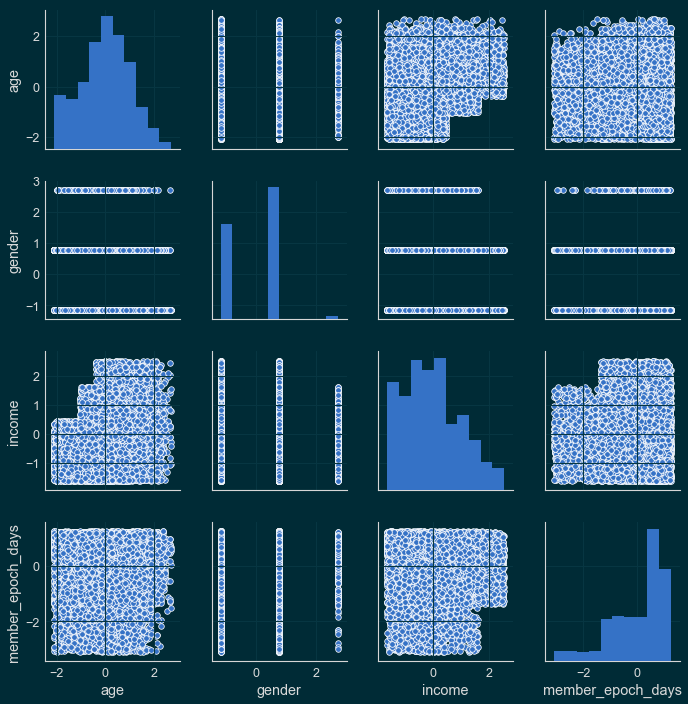

In [14]:
sns.pairplot(X_s_train)

There are some "artificial" stair-like shapes in the income-age plot, and also in the income-member_epoch_days plot. The thresholds could define clusters...

### Let's use PCA to visualize the dataset in 2D

In [15]:
from sklearn.decomposition import PCA

In [16]:
def pca_visualize(X, **kwargs):
    """ Applies PCA to get 2-D data and make a scatter plot."""
    extractor = PCA(n_components=2)
    X_pca = extractor.fit_transform(X)
    
    print('Explained variance ratio for the first two components: {}'.format(
        extractor.explained_variance_ratio_.sum()))
    
    plt.scatter(X_pca[:,0], X_pca[:,1], **kwargs)
    plt.title('PCA scatter plot')
    plt.xlabel('PCA 1')
    _ = plt.ylabel('PCA 2')

Explained variance ratio for the first two components: 0.6148986186536063


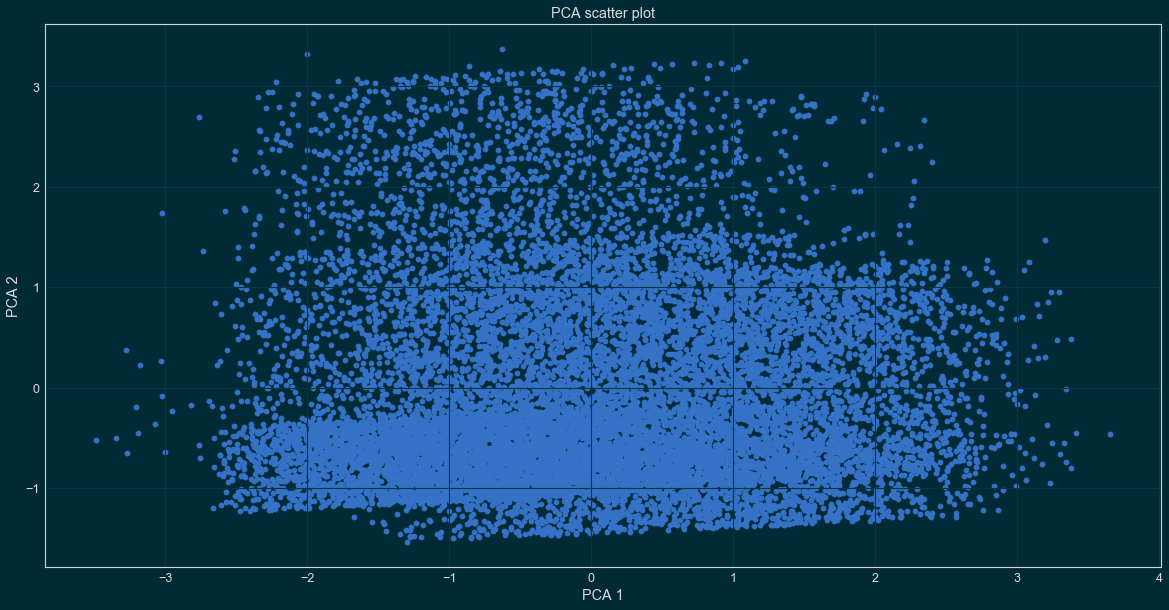

In [17]:
pca_visualize(X_s_train)

The 2-D representation looks good for GMM or DBSCAN. In next sections some clustering algorithms will be tested.

## 2. Validation Indexes <a id='indexes'/>
[Top](#top)

For comparing the models and validation, I will use the Silhouette score, and DBCV (Density Based Clustering Validation). As the main objective of this notebook is to get some new features, I will keep the clustering indexes of the methods that yield the best score in each of the metrics. I could also keep the best sample of each algorithm.

DBCV was implemented here: https://github.com/christopherjenness/DBCV

Let's try that library.

In [18]:
import DBCV
from scipy.spatial.distance import euclidean

In [19]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)

In [20]:
# %time DBCV.DBCV(X_s_train.values, cluster_labels, euclidean)

Running that function for validation takes too long. I will only use the Silhouette score, and BIC in the case of GMM. Also the elbow method, and some visualizations with PCA

## 3. Clustering algorithms <a id='clustering'/>
[Top](#top)

### 3.1. K - Means <a id='kmeans'/>
[Top](#top)

In [21]:
kmeans = KMeans(n_clusters=4)
%time kmeans.fit(X_s_train)

CPU times: user 711 ms, sys: 34.9 ms, total: 746 ms
Wall time: 376 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
cluster = kmeans.predict(X_s_train)

In [23]:
def pca_visualize_clusters(X, cluster):
    """ Visualize all the clusters using PCA. """
    for c in np.unique(cluster):
        pca_visualize(X[cluster == c], label='cluster {}'.format(c))
    plt.legend()

Explained variance ratio for the first two components: 0.704815716463888
Explained variance ratio for the first two components: 0.5955638756544016
Explained variance ratio for the first two components: 0.752752231682509
Explained variance ratio for the first two components: 0.7382034606332021


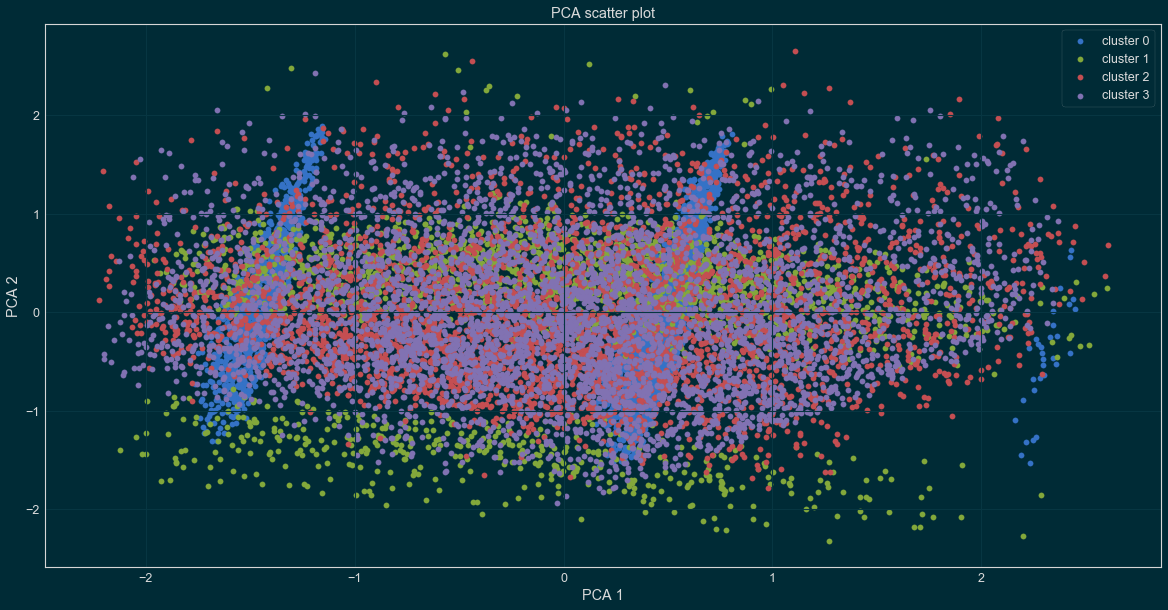

In [24]:
pca_visualize_clusters(X_s_train, cluster)

The visualization is not too informative. Let's use the Silhouette score to determine the best number of clusters.

In [25]:
from sklearn.metrics import silhouette_score
from time import time

In [179]:
def validate_clustering(X, clustering_algo, clusters):
    """ Get the Silhouette score and """
    silhouette = list()
    error = list()
    for i, n_clusters in enumerate(clusters):
        tic = time()
        method = clustering_algo(n_clusters)
        labels = method.fit_predict(X)
        silhouette.append(silhouette_score(X, labels))
        if isinstance(clustering_algo, KMeans):
            error.append(method.inertia_)
        toc = time()
        print('Algorithm {} of {} finished in {} seconds.'.format(
             i + 1, len(clusters), (toc - tic)))
    
    best_silhouette_n = clusters[np.argmax(silhouette)]
    print('The best Silhouette score is for {} clusters, and its value is: {}'.format(
        best_silhouette_n, max(silhouette)))
    if isinstance(clustering_algo, KMeans):
        print('The error for {} clusters is: {}'.format(
            best_silhouette_n, error[np.argmax(silhouette)]))
    
    plt.plot(clusters, silhouette)
    plt.title('Silhouette score')
    plt.vlines(best_silhouette_n, min(silhouette), max(silhouette), 'r')
    if isinstance(clustering_algo, KMeans):
        plt.figure()
        plt.plot(clusters, error)
        plt.title('Error')
        plt.vlines(best_silhouette_n, min(error), max(error), 'r')
    
    return silhouette, error, best_silhouette_n

Algorithm 1 of 28 finished in 3.971560001373291 seconds.
Algorithm 2 of 28 finished in 3.844151735305786 seconds.
Algorithm 3 of 28 finished in 4.026015043258667 seconds.
Algorithm 4 of 28 finished in 3.989790916442871 seconds.
Algorithm 5 of 28 finished in 4.047065019607544 seconds.
Algorithm 6 of 28 finished in 4.060275077819824 seconds.
Algorithm 7 of 28 finished in 6.428073883056641 seconds.
Algorithm 8 of 28 finished in 8.190678834915161 seconds.
Algorithm 9 of 28 finished in 7.311578989028931 seconds.
Algorithm 10 of 28 finished in 7.730564117431641 seconds.
Algorithm 11 of 28 finished in 5.563678026199341 seconds.
Algorithm 12 of 28 finished in 5.523612022399902 seconds.
Algorithm 13 of 28 finished in 5.3758628368377686 seconds.
Algorithm 14 of 28 finished in 5.156196117401123 seconds.
Algorithm 15 of 28 finished in 6.390236139297485 seconds.
Algorithm 16 of 28 finished in 5.300265073776245 seconds.
Algorithm 17 of 28 finished in 5.133867979049683 seconds.
Algorithm 18 of 28 fin

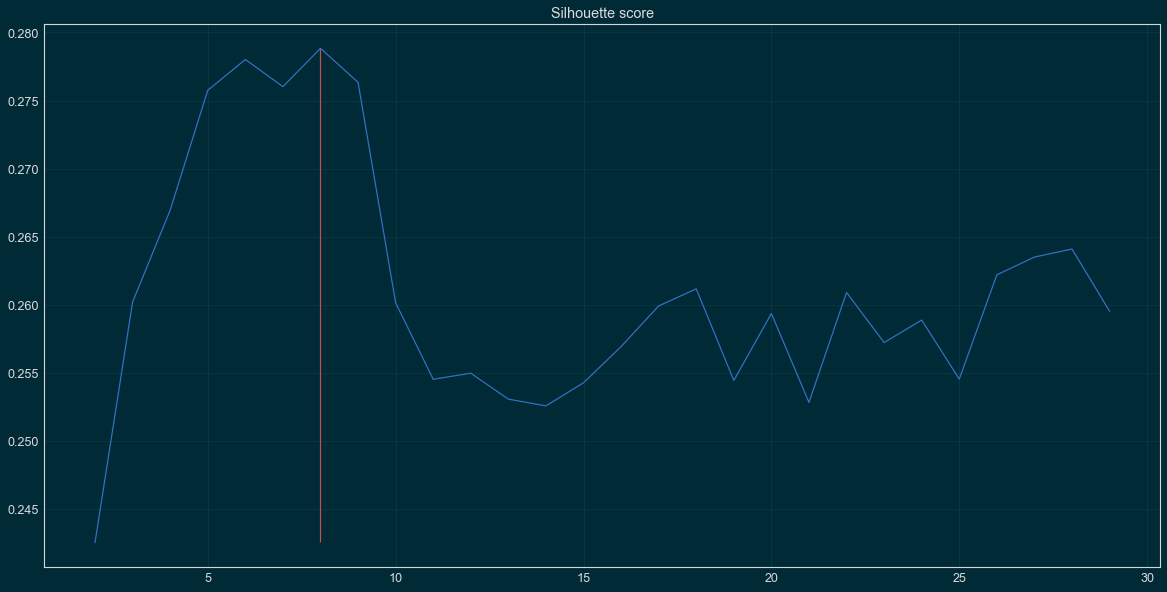

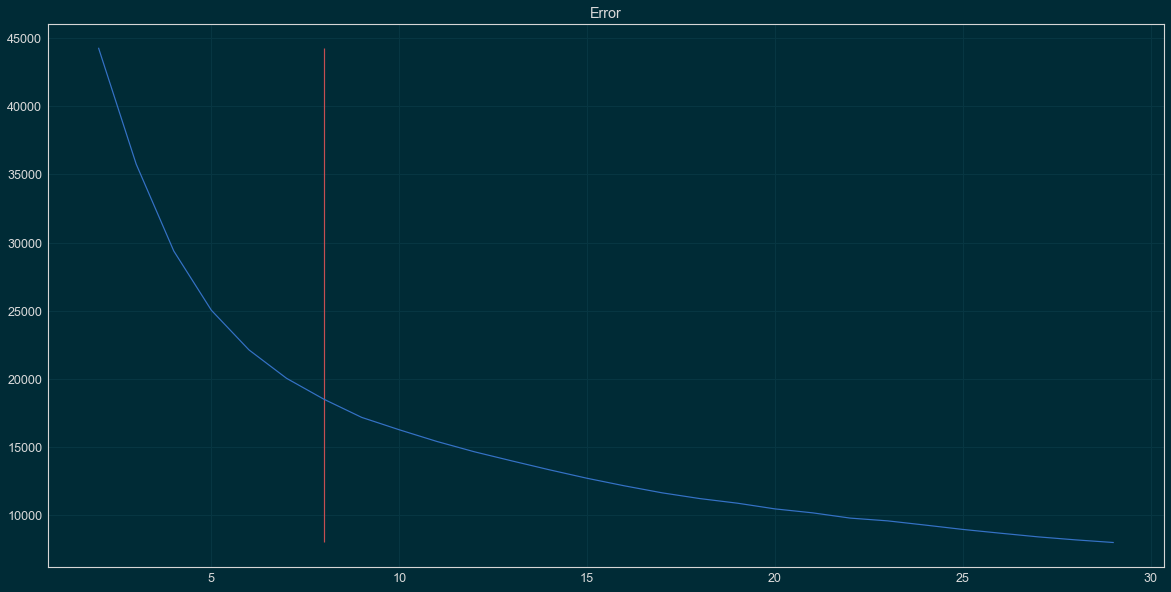

In [164]:
clusters = range(2, 30)
silhouette, error, best_n = validate_clustering(X_s_train, KMeans, clusters)

OK, let's use KMeans with n = 8

Explained variance ratio for the first two components: 0.6782136318932057
Explained variance ratio for the first two components: 0.6797952653449144
Explained variance ratio for the first two components: 0.7960990125179702
Explained variance ratio for the first two components: 0.8441243924210367
Explained variance ratio for the first two components: 0.7287183444128751
Explained variance ratio for the first two components: 0.6823408890280622
Explained variance ratio for the first two components: 0.7367031920857856
Explained variance ratio for the first two components: 0.7019972604188374


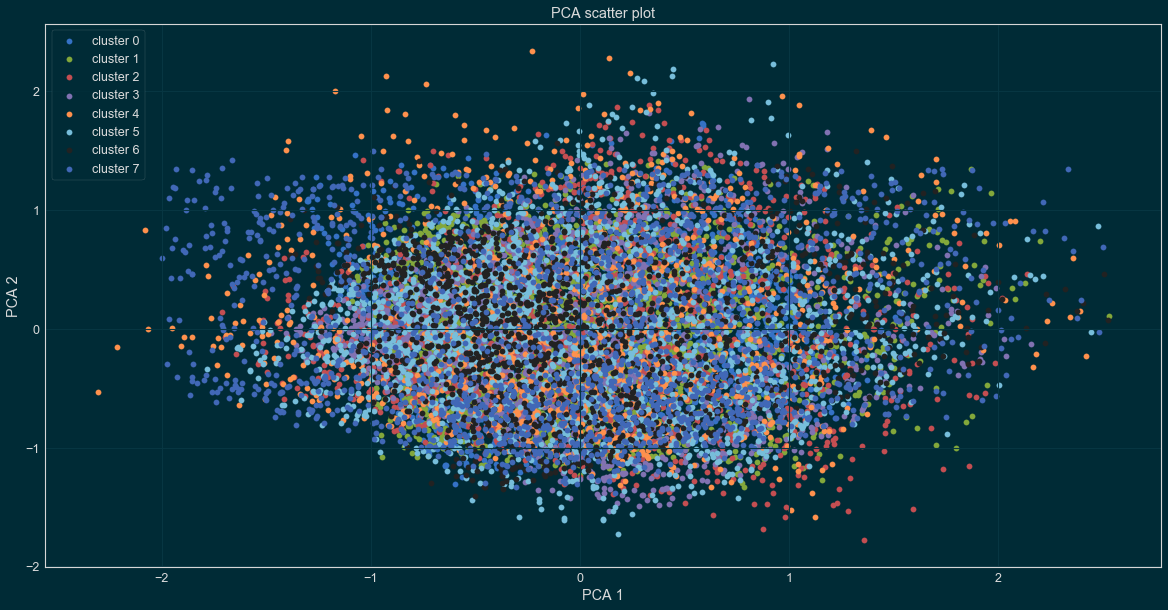

In [165]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=2018)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)
pca_visualize_clusters(X_s_train, cluster_labels)

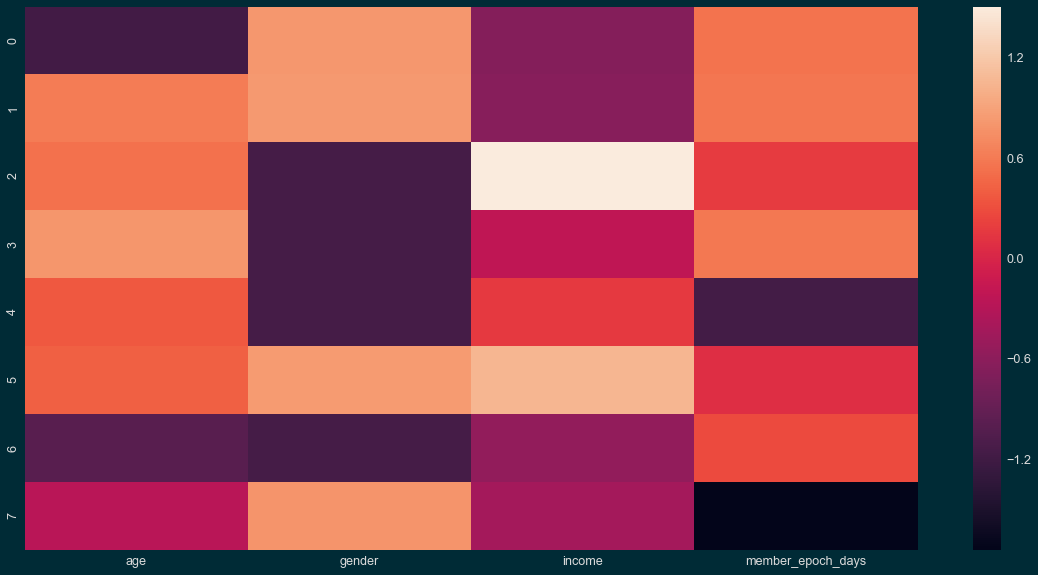

In [166]:
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

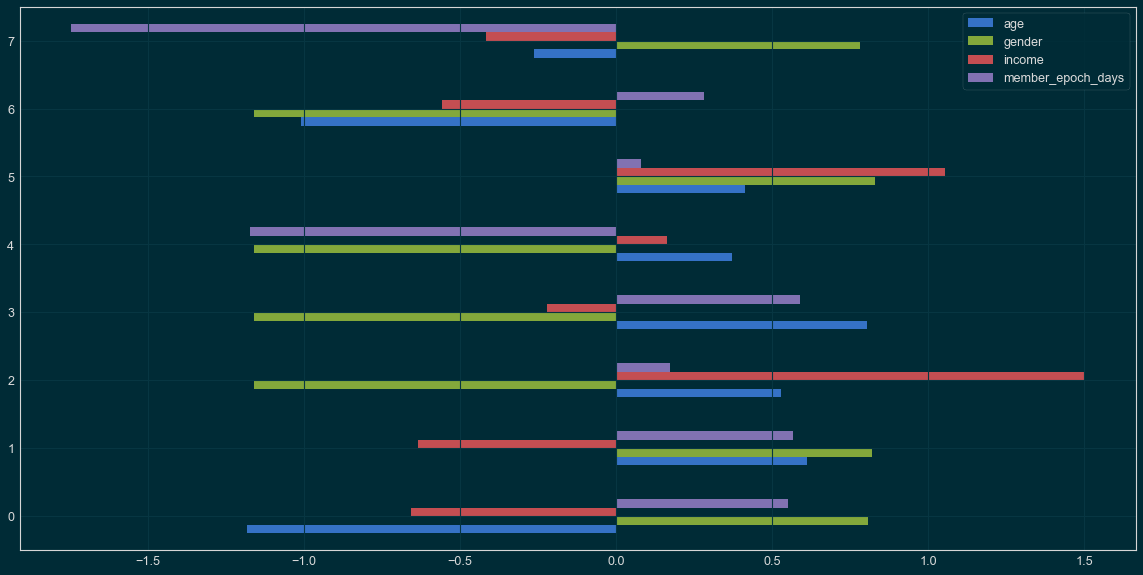

In [167]:
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

In [168]:
X_s_train.gender.unique()

array([ 0.76945298,  2.69936669, -1.16046072])

**Description of the clusters ():**

 - 0) Low income young men. They joined the app more recently than the mean.
 - 1) Low income aged men that recently joined the app.
 - 2) High income women. Sensibly older than the mean.
 - 3) Aged women that joined recently. Slightly lower income than the mean.
 - 4) Early-adopter women. Sligthly higher income and age than the mean.
 - 5) High income men. Sensibly older than the mean.
 - 6) Low income young women. They joined the app more recently than the mean.
 - 7) Early-adopter men. Sligthly lower income and age than the mean.
 
 Reorganized (shows that for every "male" cluster there is a very similar "female" cluster, with minor differences):
 - 4) Early-adopter women. Sligthly higher income and age than the mean.
 - 7) Early-adopter men. Sligthly lower income and age than the mean.
  
  
 - 0) Low income young men. They joined the app more recently than the mean.
 - 6) Low income young women. They joined the app more recently than the mean.
  
  
 - 2) High income women. Sensibly older than the mean.
 - 5) High income men. Sensibly older than the mean.
  
  
 - 1) Low income aged men that recently joined the app. 
 - 3) Aged women that joined recently. Slightly lower income than the mean.


In every cluster it seems like the female customers have a slightly higher income than the male customers. Other genders don't seem to be enough to influence the clusters in a noticeable way.

Text(0.5, 1.0, 'Number of members per cluster')

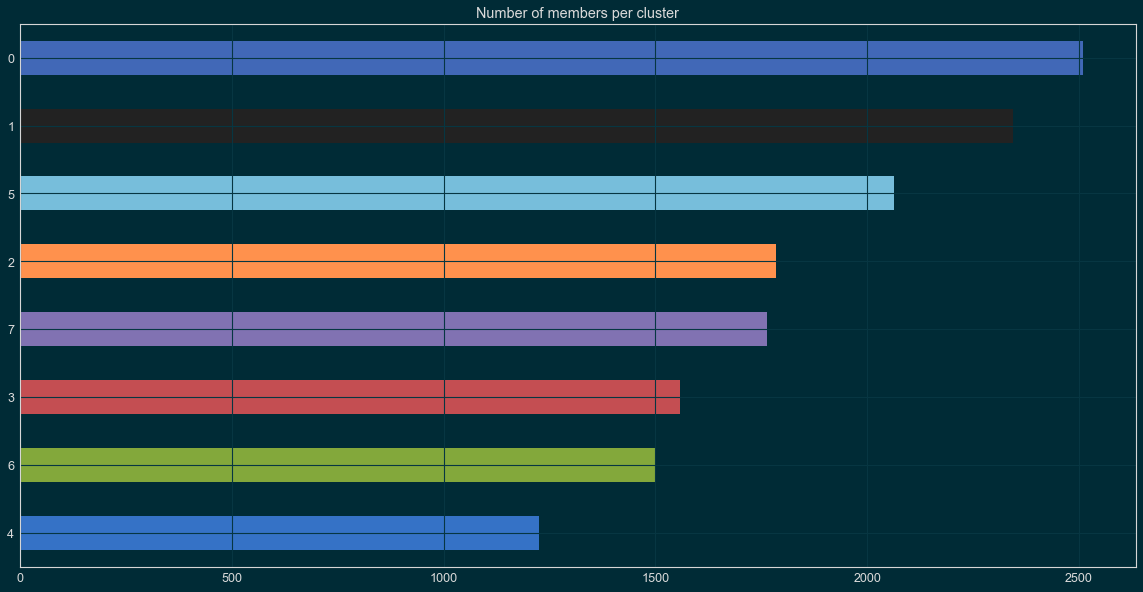

In [169]:
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

In [170]:
for label in range(n_clusters):
    X_clust = X_s_train[cluster_labels == label]
    print('Cluster {}'.format(label))
    print(X_clust.describe())
    print('-'*100)

Cluster 0
               age       gender       income  member_epoch_days
count  2509.000000  2509.000000  2509.000000        2509.000000
mean     -1.181806     0.806374    -0.657129           0.550342
std       0.527424     0.264424     0.601200           0.505595
min      -2.093446     0.769453    -1.638707          -1.210158
25%      -1.633281     0.769453    -1.175796           0.387876
50%      -1.173117     0.769453    -0.666594           0.643084
75%      -0.712953     0.769453    -0.157392           0.919759
max      -0.310310     2.699367     0.861012           1.246521
----------------------------------------------------------------------------------------------------
Cluster 1
               age       gender       income  member_epoch_days
count  2345.000000  2345.000000  2345.000000        2345.000000
mean      0.613158     0.820478    -0.634477           0.568314
std       0.602342     0.309697     0.553269           0.513905
min      -0.252789     0.769453    -1.638707   

### 3.2. Hierarchical (Ward) <a id='ward'/>
[Top](#top)

In [66]:
from scipy.cluster.hierarchy import dendrogram, ward, fcluster
import seaborn as sns

In [59]:
%time linkage_matrix = ward(X_s_train)

CPU times: user 8.68 s, sys: 935 ms, total: 9.61 s
Wall time: 9.72 s


CPU times: user 105 ms, sys: 3.32 ms, total: 108 ms
Wall time: 111 ms


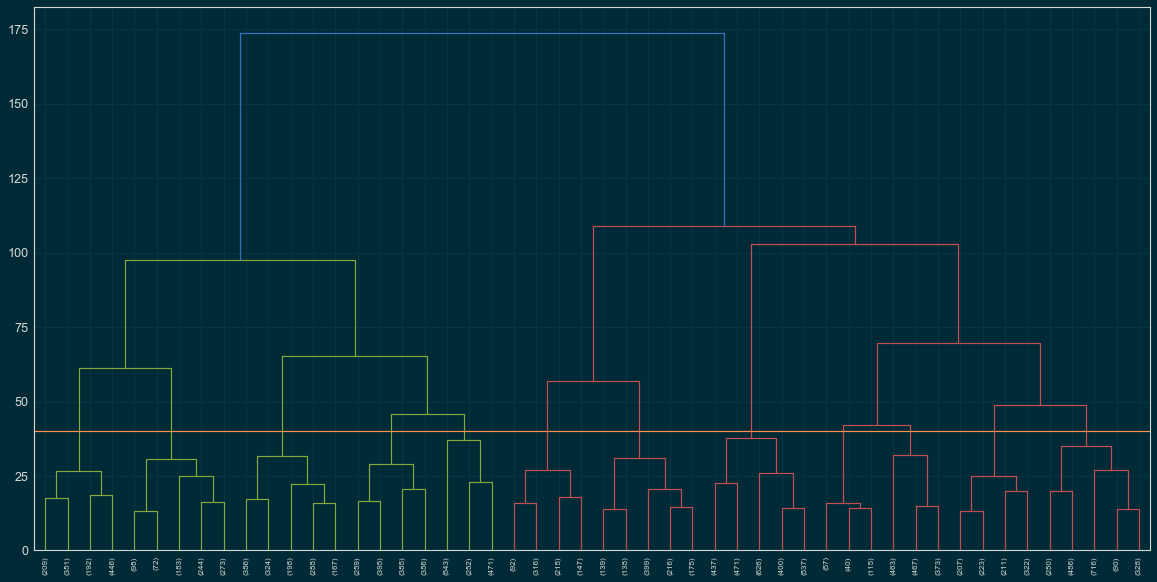

In [60]:
p = 50
%time ddg = dendrogram(linkage_matrix, truncate_mode='lastp', p=p)
plt.hlines(40, 0, 10 * p, colors='y')

With that limit, maybe 12 clusters would be reasonable. Let's check that with the Silhouette score.

CPU times: user 9.98 s, sys: 942 ms, total: 10.9 s
Wall time: 11.1 s


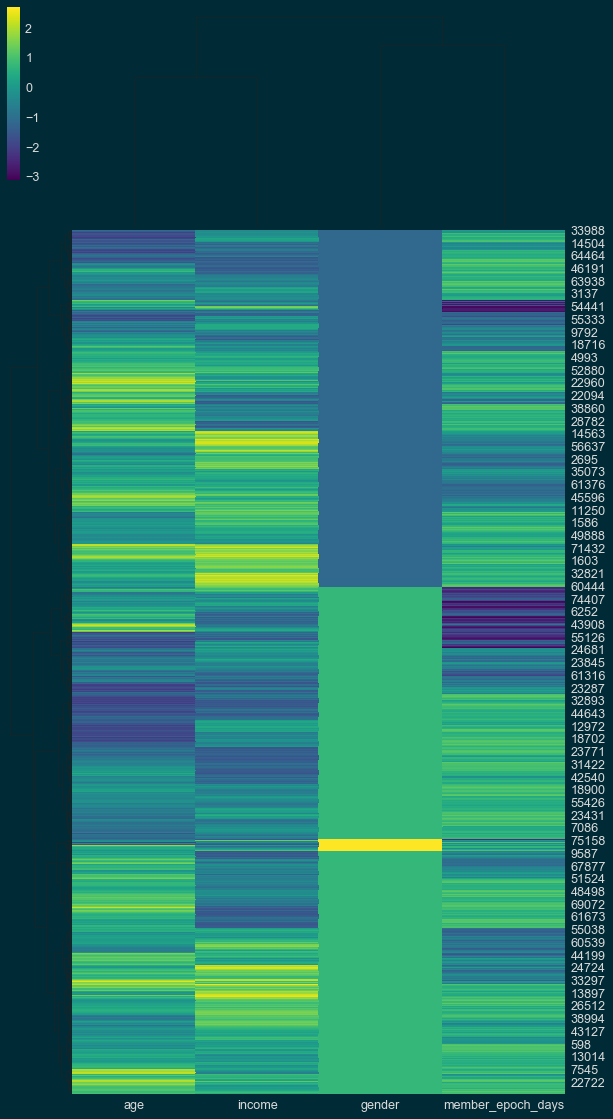

In [63]:
%time sns.clustermap(X_s_train, figsize=(10, 20), method='ward', cmap='viridis')

The most noticeable division seems to be by gender. The other features also seem to cluster the data. For example, "age" seems to divide the "male" cluster pretty well.

In [122]:
from collections import defaultdict

In [129]:
# cut_dists = np.arange(10, 150, 10)
cut_dists = np.exp(np.linspace(0, 5.5, 50))
results = defaultdict(dict)

for i, max_d in enumerate(cut_dists):
    tic = time()
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    n_clusters = len(np.unique(clusters))
    
    results['n_clusters'][max_d] = n_clusters
    if n_clusters >= 2:
        results['score'][max_d] = silhouette_score(X_s_train, clusters)
    else:
        results['score'][max_d] = 0
    
    toc = time()
    print('Algorithm {} of {} finished in {} seconds.'.format(
        i + 1, len(cut_dists), (toc - tic)))

Algorithm 1 of 50 finished in 3.7367076873779297 seconds.
Algorithm 2 of 50 finished in 3.8816709518432617 seconds.
Algorithm 3 of 50 finished in 3.9746811389923096 seconds.
Algorithm 4 of 50 finished in 3.8776419162750244 seconds.
Algorithm 5 of 50 finished in 3.817178726196289 seconds.
Algorithm 6 of 50 finished in 3.912775993347168 seconds.
Algorithm 7 of 50 finished in 3.7911176681518555 seconds.
Algorithm 8 of 50 finished in 3.657252073287964 seconds.
Algorithm 9 of 50 finished in 3.956707715988159 seconds.
Algorithm 10 of 50 finished in 4.281733751296997 seconds.
Algorithm 11 of 50 finished in 3.8289880752563477 seconds.
Algorithm 12 of 50 finished in 3.7234349250793457 seconds.
Algorithm 13 of 50 finished in 3.7405779361724854 seconds.
Algorithm 14 of 50 finished in 3.8724400997161865 seconds.
Algorithm 15 of 50 finished in 3.951249122619629 seconds.
Algorithm 16 of 50 finished in 3.644850969314575 seconds.
Algorithm 17 of 50 finished in 3.9099669456481934 seconds.
Algorithm 18 

The best Silhouette score is for 2 clusters (maximum distance = 111.52911905915602), and its value is: 0.2773163761270585


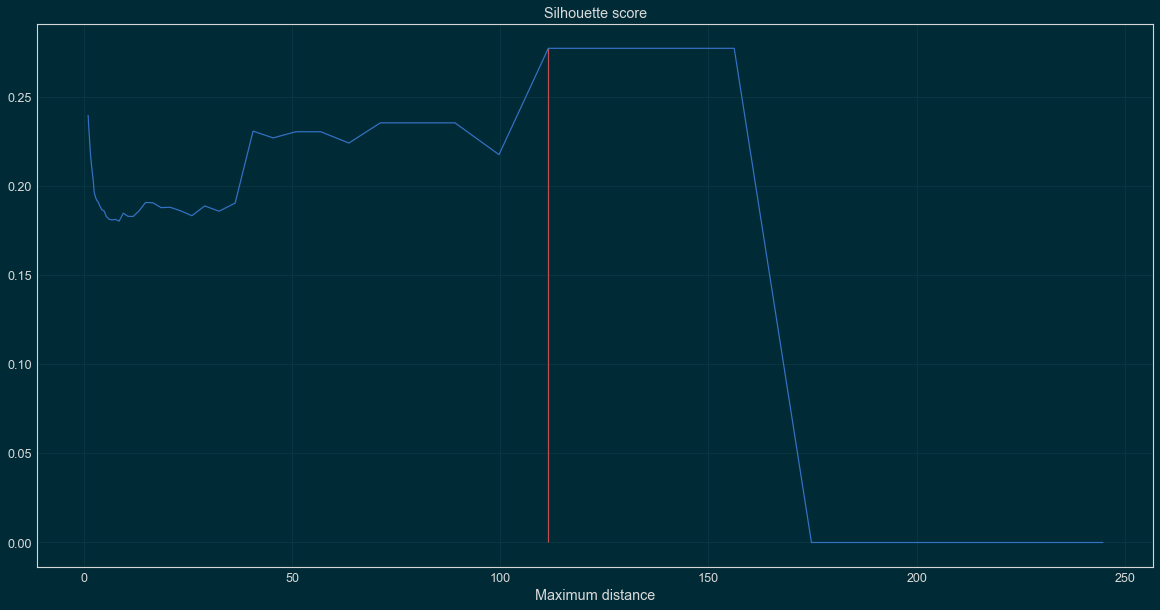

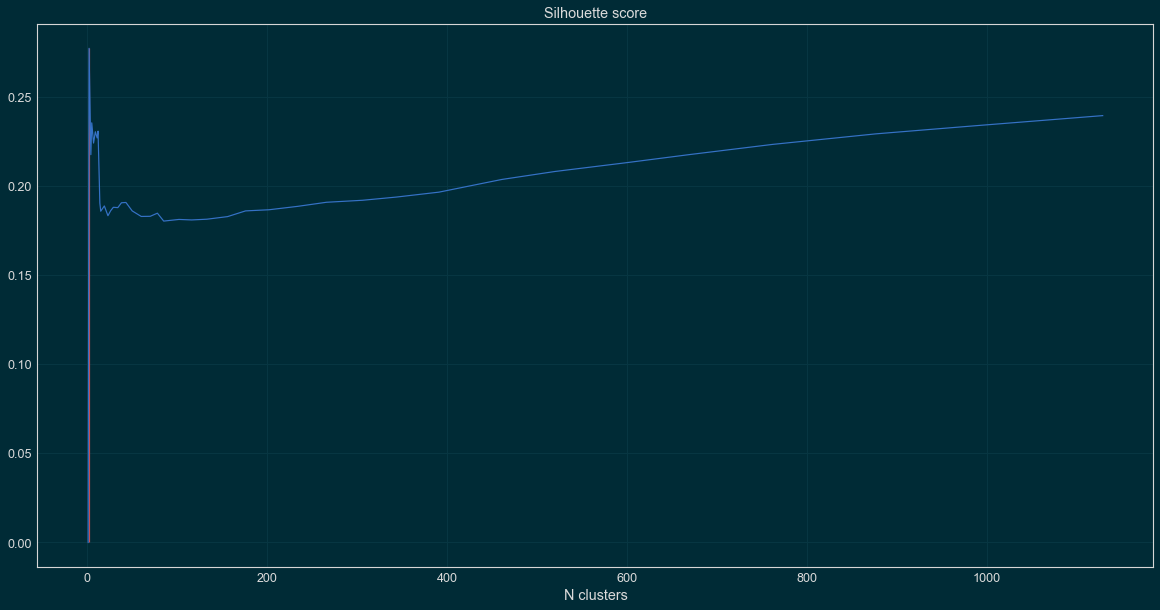

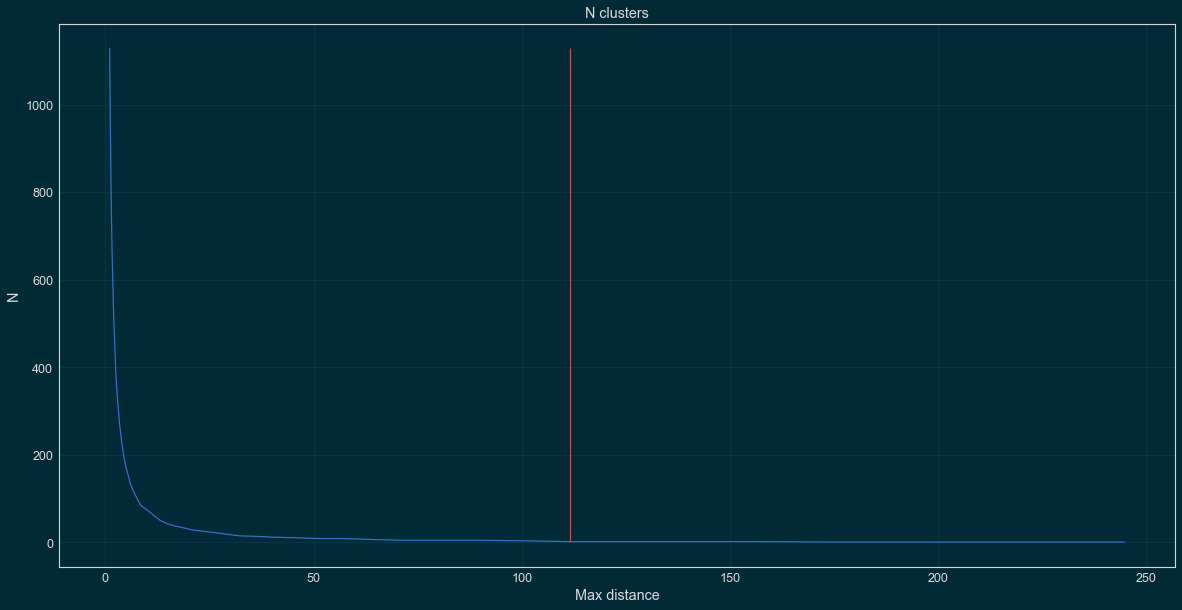

In [141]:
best_d, best_score = max(results['score'].items(), key= lambda x: x[1])
best_n_clust = results['n_clusters'][best_d]
print(
    'The best Silhouette score is for {} clusters (maximum distance '.format(
    best_n_clust) + '= {}), and its value is: {}'.format(best_d, best_score))

# Plot silhouette score vs distance
m_dists = results['score'].keys()
scores = results['score'].values()
plt.plot(m_dists, scores)
plt.title('Silhouette score')
plt.vlines(best_d, min(scores), max(scores), 'r')
plt.xlabel('Maximum distance')

# Plot silhouette score vs n_clusters
plt.figure()
n, score_n = zip(*((results['n_clusters'][d], results['score'][d]) 
                   for d in results['n_clusters'].keys()))
plt.plot(n, score_n)
plt.title('Silhouette score')
plt.vlines(best_n_clust, min(score_n), max(score_n), 'r')
plt.xlabel('N clusters')

# Plot n_clusters vs distance
plt.figure()
m_dists = results['n_clusters'].keys()
n = results['n_clusters'].values()
plt.plot(m_dists, n)
plt.title('N clusters')
plt.xlabel('Max distance')
plt.ylabel('N')
plt.vlines(best_d, 0, max(n), 'r')

Zooming in the area of interest...

Text(0.5, 0, 'N clusters')

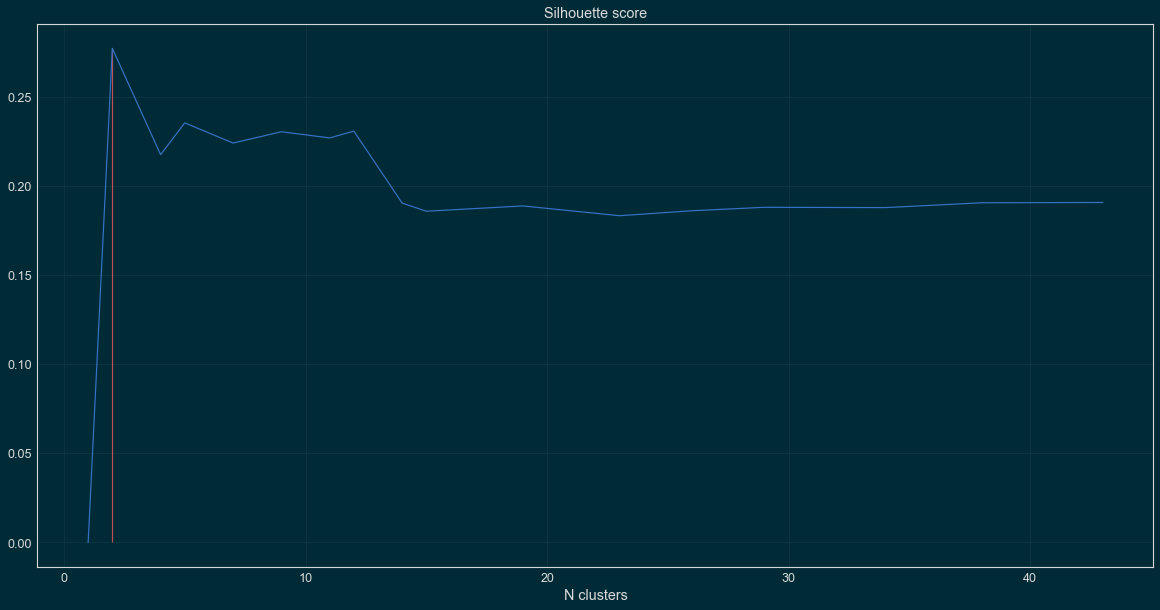

In [139]:
# Plot silhouette score vs n_clusters
n, score_n = zip(*((results['n_clusters'][d], results['score'][d]) 
                   for d in results['n_clusters'].keys()))
n = np.array(n)
score_n = np.array(score_n)
plt.plot(n[n<50], score_n[n<50])
plt.title('Silhouette score')
plt.vlines(best_n_clust, min(score_n[n<20]), max(score_n[n<20]), 'r')
plt.xlabel('N clusters')

It can be seen that about after 12 clusters the silhouette score decreases sensibly. That is in agreement with the initial intuition when looking at the dendrogram. As 12 clusters may be more informative than 2 (probably divided by gender), that may be the chosen number of clusters. Let's visualize both cases.

Let's visualize the results

Explained variance ratio for the first two components: 0.7517565478399464
Explained variance ratio for the first two components: 0.7548832827480709


Text(0.5, 1.0, 'Number of members per cluster')

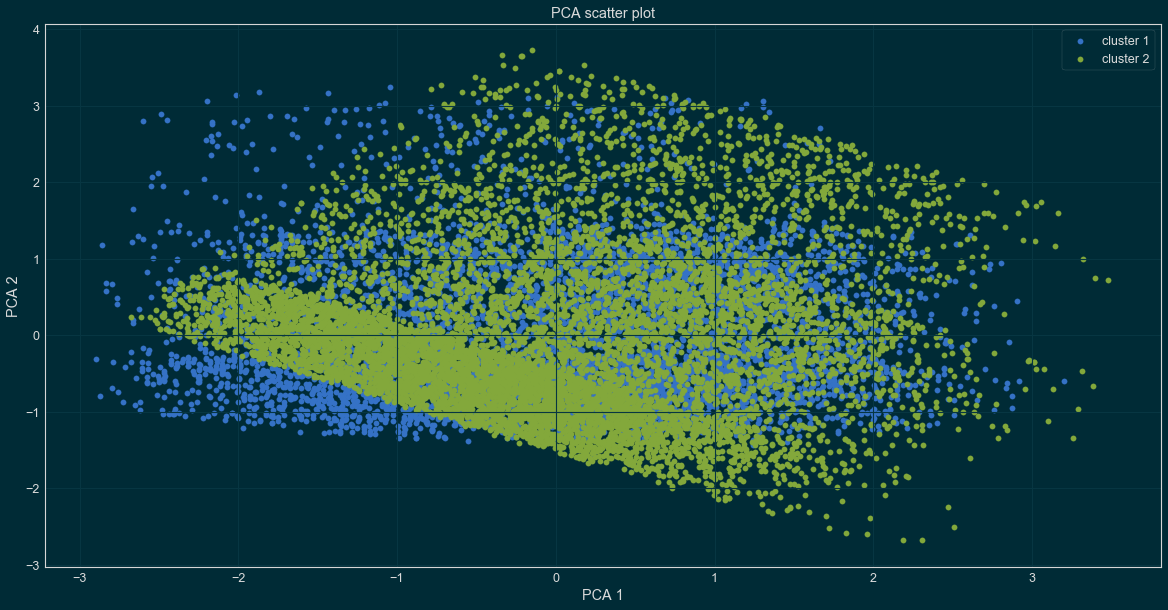

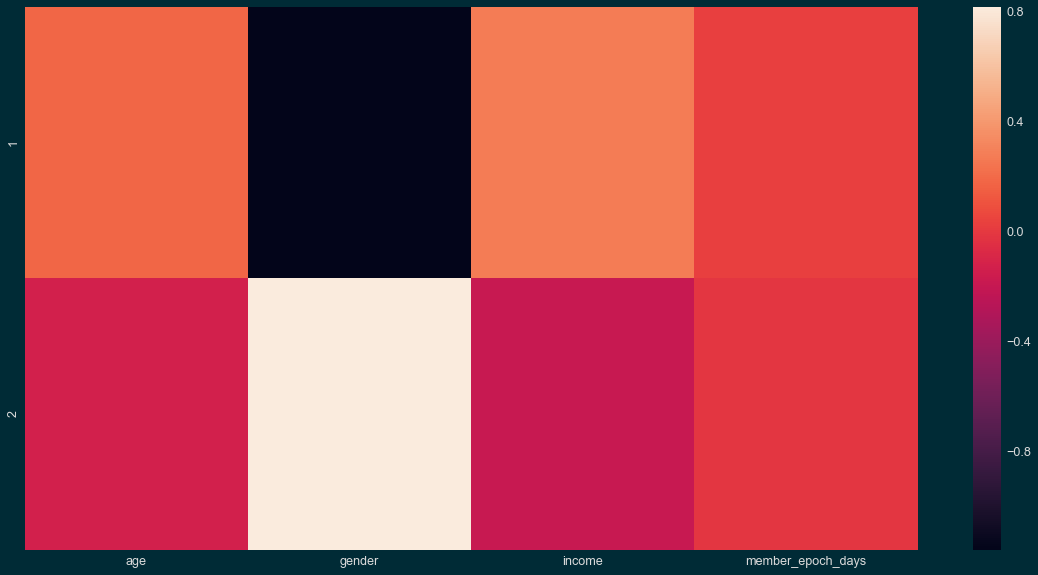

<Figure size 1440x720 with 0 Axes>

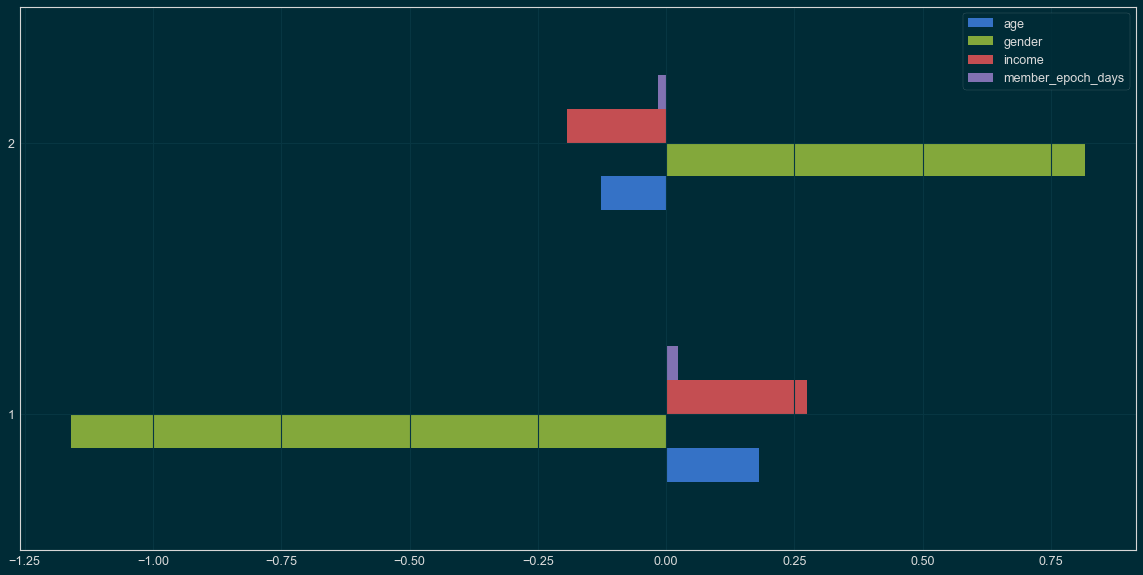

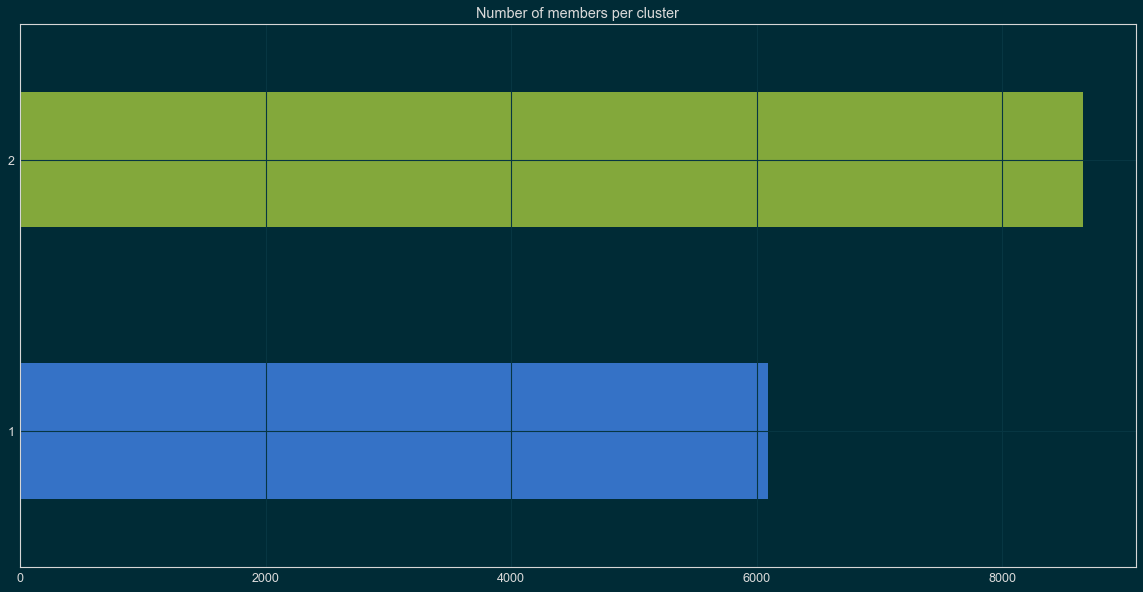

In [144]:
max_d = best_d
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

That is just dividing by gender. Let's try with 12 clusters.

In [149]:
res_df = pd.DataFrame(results)
res_df.index.name = 'distance'
res_df = res_df.reset_index()
res_df.head()

,distance,n_clusters,score
0,1.000000,1129,0.239544
1,1.118787,988,0.233888
2,1.251684,877,0.229317
3,1.400367,762,0.223394
4,1.566713,670,0.217705


In [152]:
res_df.sort_values(by='n_clusters').head(20)

,distance,n_clusters,score
49,244.691932,1,0.000000
46,174.734085,1,0.000000
48,218.711848,1,0.000000
47,195.490191,1,0.000000
45,156.181752,2,0.277316
44,139.599207,2,0.277316
43,124.777308,2,0.277316
42,111.529119,2,0.277316
41,99.687552,4,0.217634
40,89.103260,5,0.235490


In [156]:
dist_12 = res_df[res_df.n_clusters == 12].distance.values[0]
dist_12

40.61273277762122

Explained variance ratio for the first two components: 0.8262869906716728
Explained variance ratio for the first two components: 0.7880787734266311
Explained variance ratio for the first two components: 0.805696476672036
Explained variance ratio for the first two components: 0.8118939349798575
Explained variance ratio for the first two components: 0.8878030654085172
Explained variance ratio for the first two components: 0.8028703052344557
Explained variance ratio for the first two components: 0.7855397756543196
Explained variance ratio for the first two components: 0.8953762720548761
Explained variance ratio for the first two components: 0.750930335637805
Explained variance ratio for the first two components: 0.7940783668945945
Explained variance ratio for the first two components: 0.8740983352959915
Explained variance ratio for the first two components: 0.8705807721661643


Text(0.5, 1.0, 'Number of members per cluster')

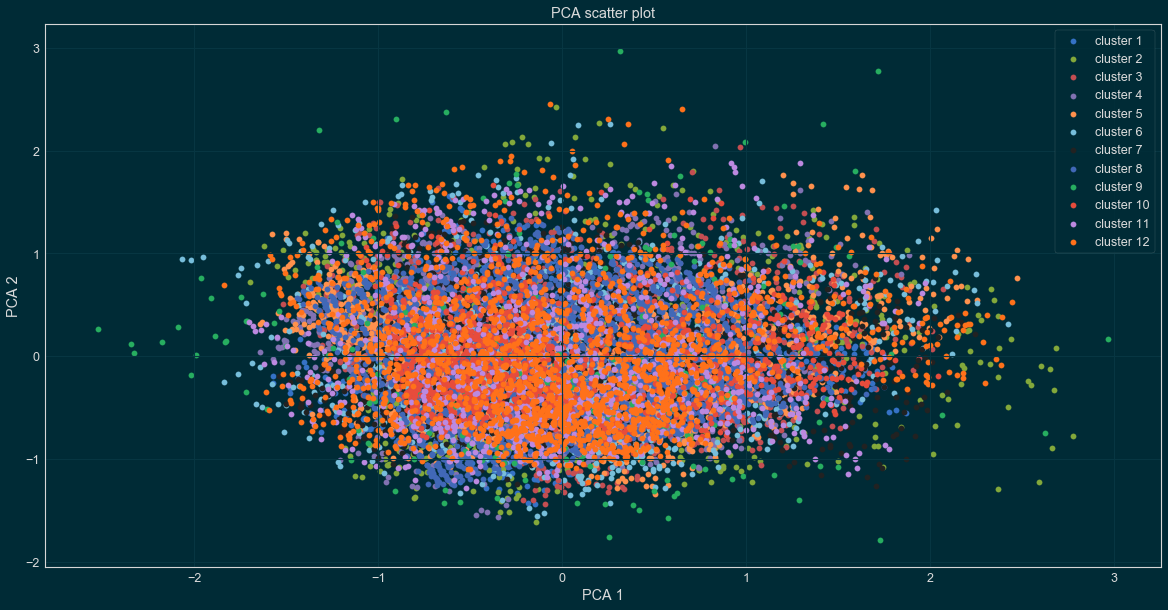

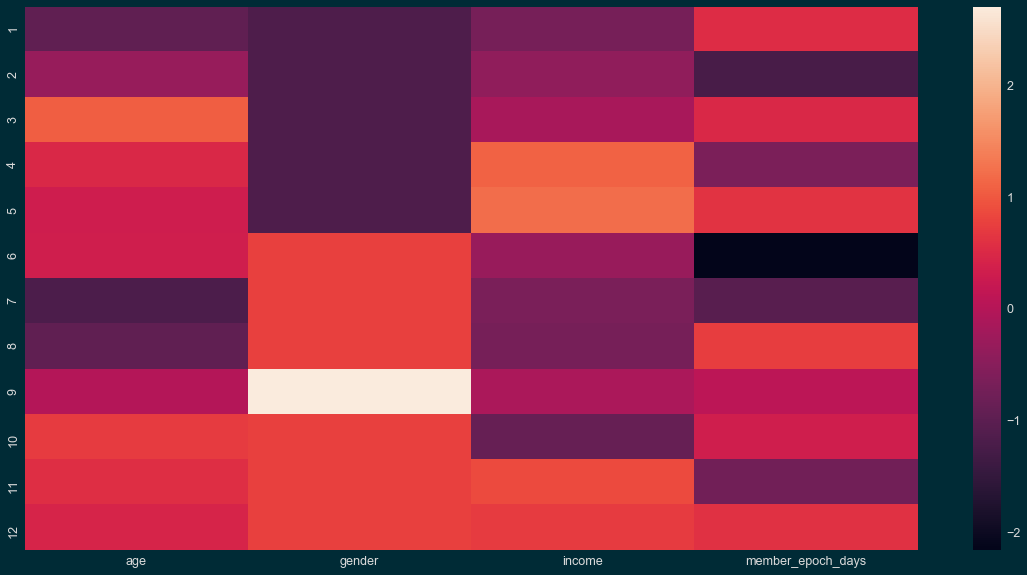

<Figure size 1440x720 with 0 Axes>

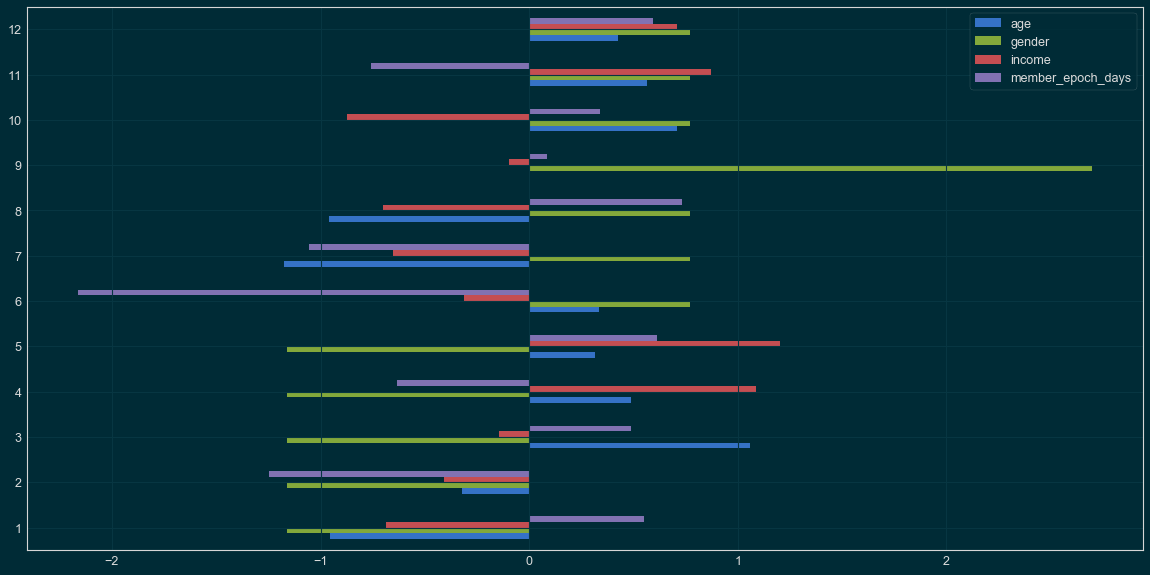

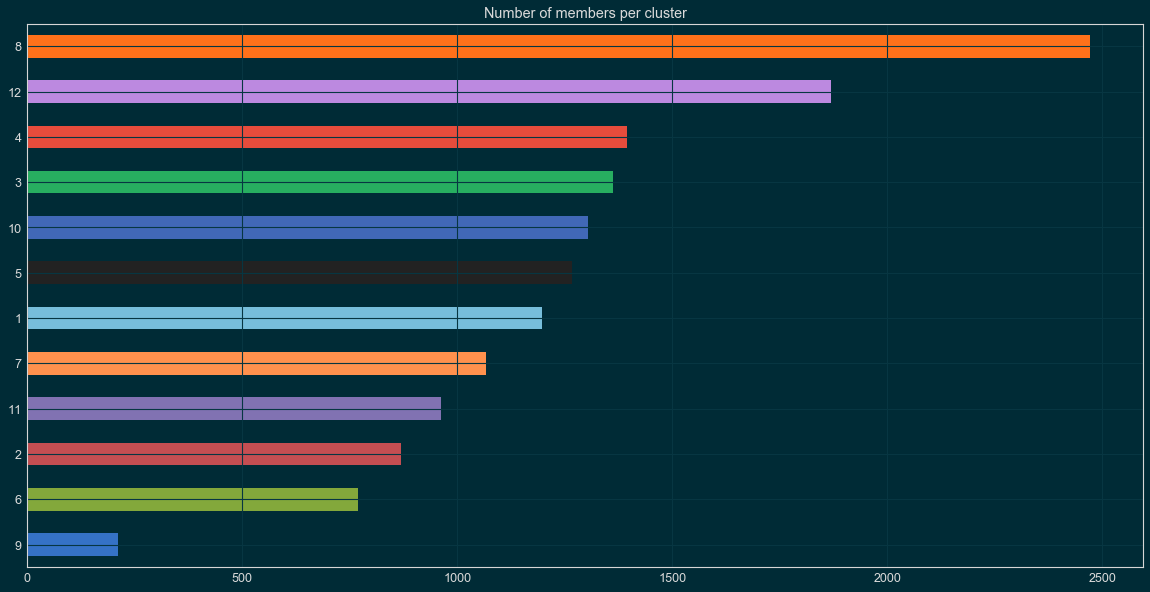

In [157]:
max_d = dist_12
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

What about 9?

In [158]:
dist_9 = res_df[res_df.n_clusters == 9].distance.values[0]
dist_9

50.83430533655655

Explained variance ratio for the first two components: 0.8262869906716723
Explained variance ratio for the first two components: 0.7880787734266305
Explained variance ratio for the first two components: 0.8056964766720371
Explained variance ratio for the first two components: 0.7754377926493254
Explained variance ratio for the first two components: 0.8028703052344558
Explained variance ratio for the first two components: 0.7855397756543203
Explained variance ratio for the first two components: 0.8953762720548752
Explained variance ratio for the first two components: 0.725550853919291
Explained variance ratio for the first two components: 0.7242155178927965


Text(0.5, 1.0, 'Number of members per cluster')

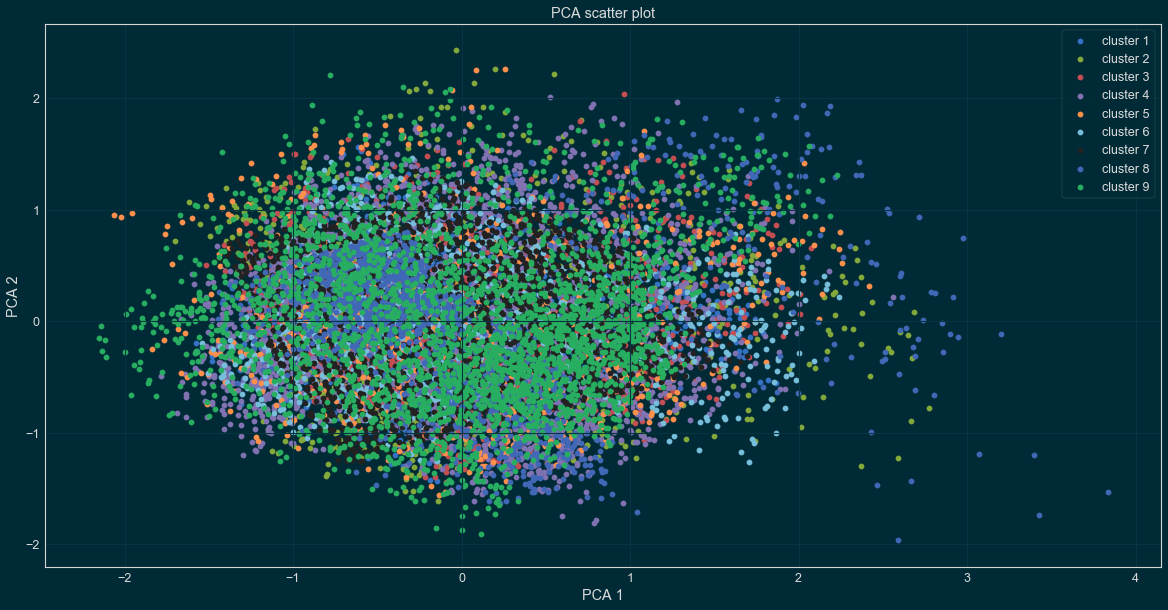

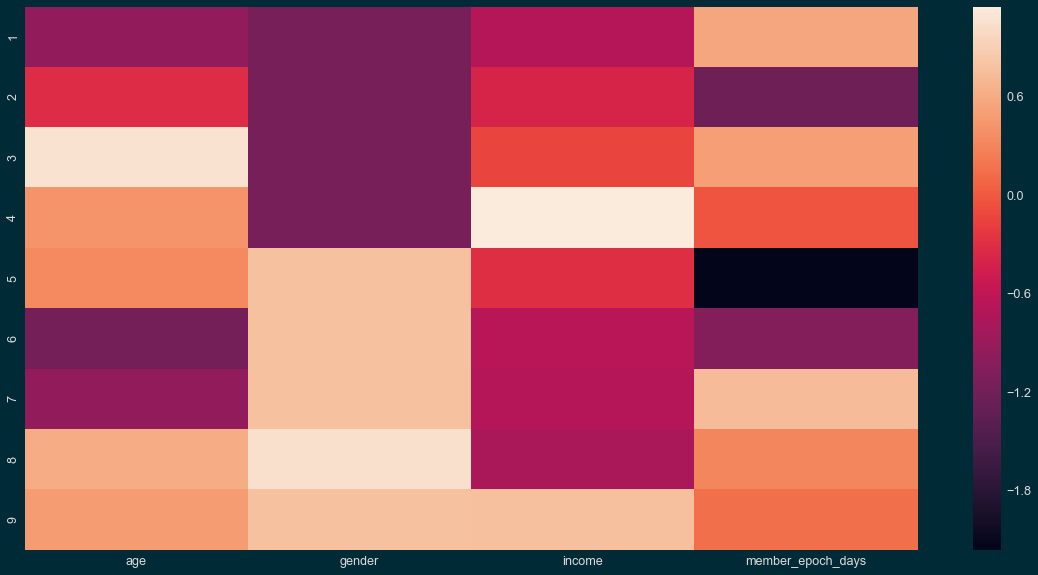

<Figure size 1440x720 with 0 Axes>

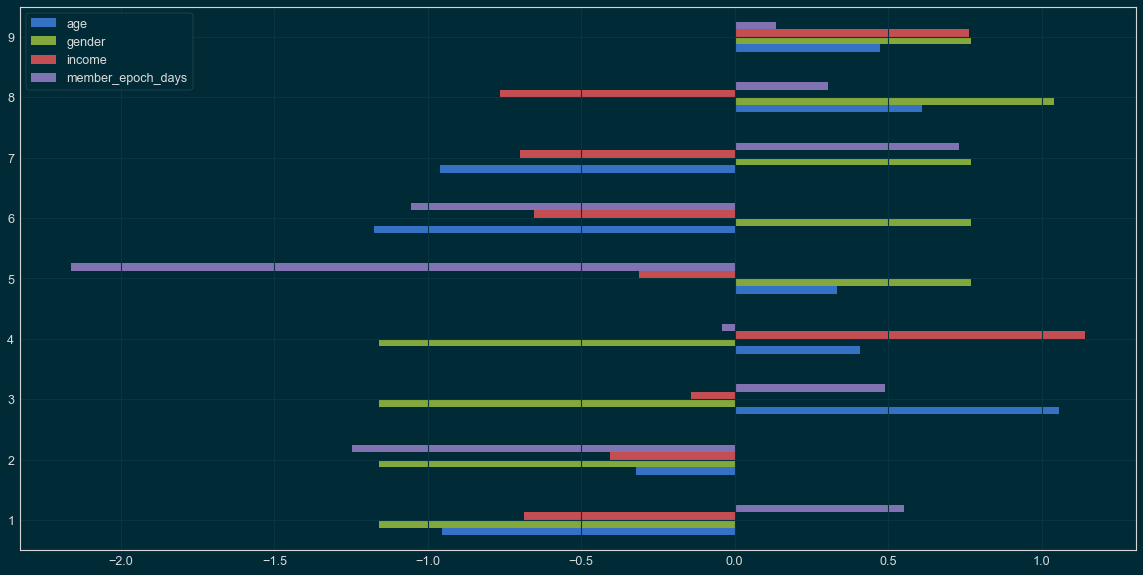

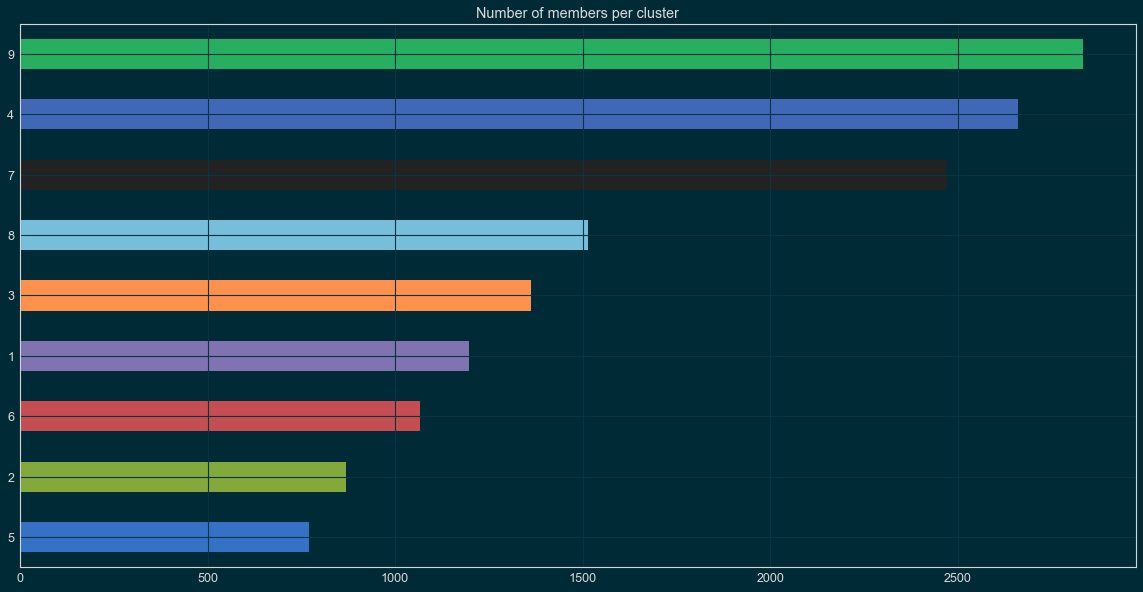

In [159]:
max_d = dist_9
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

The 9 clusters case looks very similar to that found by K-Means, with the difference that Ward seems to have found a new cluster for the people that chose "Other" in gender. We should check if that is the case. I will keep both cases (9 and 12) to generate new features.

### 3.3. GMM <a id='gmm'/>
[Top](#top)

In [161]:
from sklearn.mixture import GaussianMixture

Algorithm 1 of 28 finished in 3.9240729808807373 seconds.
Algorithm 2 of 28 finished in 3.966745138168335 seconds.
Algorithm 3 of 28 finished in 4.12457013130188 seconds.
Algorithm 4 of 28 finished in 3.9471843242645264 seconds.
Algorithm 5 of 28 finished in 4.295415163040161 seconds.
Algorithm 6 of 28 finished in 4.592146873474121 seconds.
Algorithm 7 of 28 finished in 5.0281572341918945 seconds.
Algorithm 8 of 28 finished in 4.6705498695373535 seconds.
Algorithm 9 of 28 finished in 4.212474822998047 seconds.
Algorithm 10 of 28 finished in 5.195073127746582 seconds.
Algorithm 11 of 28 finished in 4.459420919418335 seconds.
Algorithm 12 of 28 finished in 4.4105730056762695 seconds.
Algorithm 13 of 28 finished in 4.441656827926636 seconds.
Algorithm 14 of 28 finished in 4.18648099899292 seconds.
Algorithm 15 of 28 finished in 4.5920891761779785 seconds.
Algorithm 16 of 28 finished in 4.902123928070068 seconds.
Algorithm 17 of 28 finished in 4.65671706199646 seconds.
Algorithm 18 of 28 f

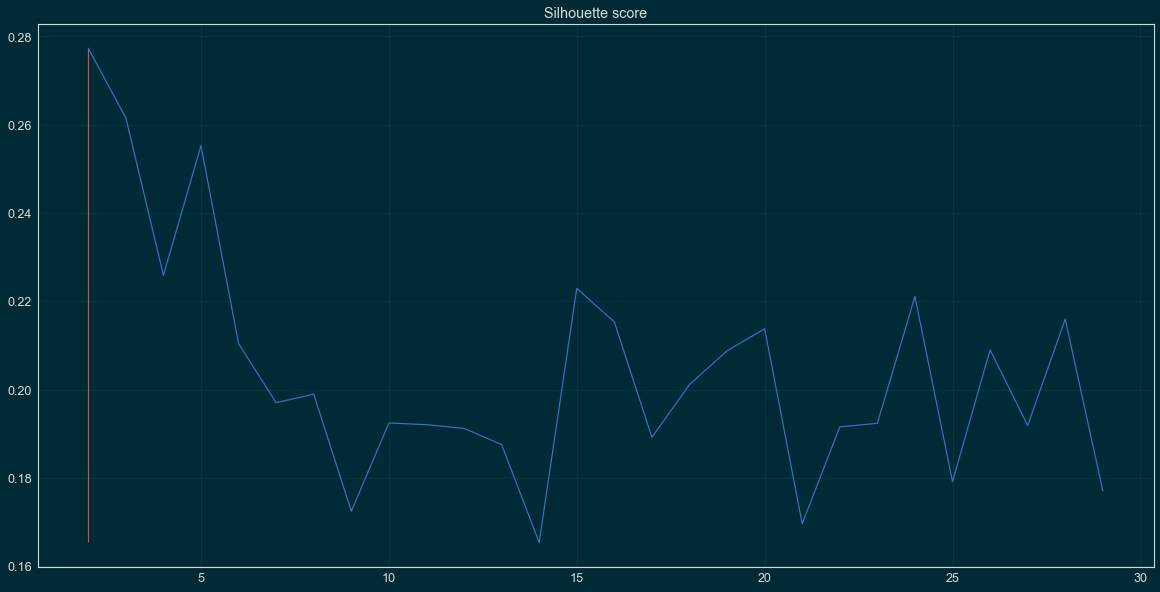

In [180]:
clusters = range(2, 30)
silhouette, error, best_n = validate_clustering(X_s_train, GaussianMixture, clusters)

We should check if the case with 2 clusters is just looking for gender. I also would like to look at the 5-clusters and 15-clusters cases.

### 3.4. DBSCAN <a id='dbscan'/>
[Top](#top)

## 4. Results Analysis <a id='results'/>
[Top](#top)